#### Imports and configs

In [1]:

import pandas as pd
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
RANDOM_STATE = 42
sns.set_context("talk")
pastel_palette = sns.color_palette("Set2")
sns.set_palette(pastel_palette)

#### Read data and transform columns data types

In [2]:
data = pd.read_csv('ames.csv', delimiter=',')

categoricalColumns = data.select_dtypes(include='object').columns.to_list()
categoricalColumns = categoricalColumns + ["Year_Built", "Year_Remod_Add",
                                           "BsmtFin_SF_1", "Bsmt_Full_Bath", 
                                           "Bsmt_Half_Bath", "Full_Bath", 
                                           "Bedroom_AbvGr", "Kitchen_AbvGr", 
                                           "TotRms_AbvGrd", "Fireplaces", 
                                           "Garage_Cars", "Mo_Sold", "Year_Sold"]
numericalColumns = [column for column in data.columns if column not in categoricalColumns and column != "Sale_Price"]
for column in categoricalColumns:
    data[column] = data[column].astype('object')

#print(data[categoricalColumns].dtypes)


train = data.iloc[0:2000]
test = data.iloc[2000:]
y_train = train.Sale_Price.values
train = train.drop(["Sale_Price"], axis=1)
y_test = test["Sale_Price"].values
test = test.drop(["Sale_Price"], axis=1)
X_train = train
X_test = test

#### Initialize ML-Models

In [3]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
lasso = Lasso(random_state=RANDOM_STATE)
ridge = Ridge(random_state=RANDOM_STATE)
svr = SVR()

#### Create transformers and preprocessor

In [4]:
numericalColumnsTransformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
categoricalColumnsTransformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numericalColumnsTransformer, numericalColumns), ('cat', categoricalColumnsTransformer, categoricalColumns)])

#### Create stack and apply preprocessor to it

In [5]:
stack = StackingCVRegressor(regressors=(rf,ridge, svr), meta_regressor=lasso)
stackPipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', stack)])

#### Fit stack via grid search and training data

In [6]:
param_grid = {
    # Random Forest Regressor hyperparameters
    'model__randomforestregressor__n_estimators': [50, 100, 200],  # Number of trees in the forest

    # Ridge Regressor hyperparameters
    'model__ridge__alpha': [0.1, 1.0, 10.0],  # Regularization strength: smaller values specify stronger regularization

    # Support Vector Regressor hyperparameters
    'model__svr__C': [0.1, 1.0, 10.0],  # Regularization parameter: trades off correct classification of training points against maximization of the decision function's margin

    # Meta Lasso Regressor hyperparameters
    #'model__meta_lasso__alpha': [0.1, 1.0, 10.0],  # Regularization strength of the meta-regressor

    # Preprocessor hyperparameters
    #'preprocessor__num__with_mean': [True, False],  # Whether to center numerical features before scaling
    #'preprocessor__imputer__strategy': ['mean', 'median', 'most_frequent'],  # Strategy for imputing missing values in categorical features
}


In [7]:
gridSearch = GridSearchCV(estimator=stackPipeline, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, refit=True)

In [8]:
gridSearch.fit(X_train, y_train)
print(f'Best Parameters: {gridSearch.best_params_ }   Score: {gridSearch.best_score_}')
y_test_pred = gridSearch.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Best Parameters: {'model__randomforestregressor__n_estimators': 50, 'model__ridge__alpha': 0.1, 'model__svr__C': 1.0}   Score: -26623.997077883058


#### Visualize results

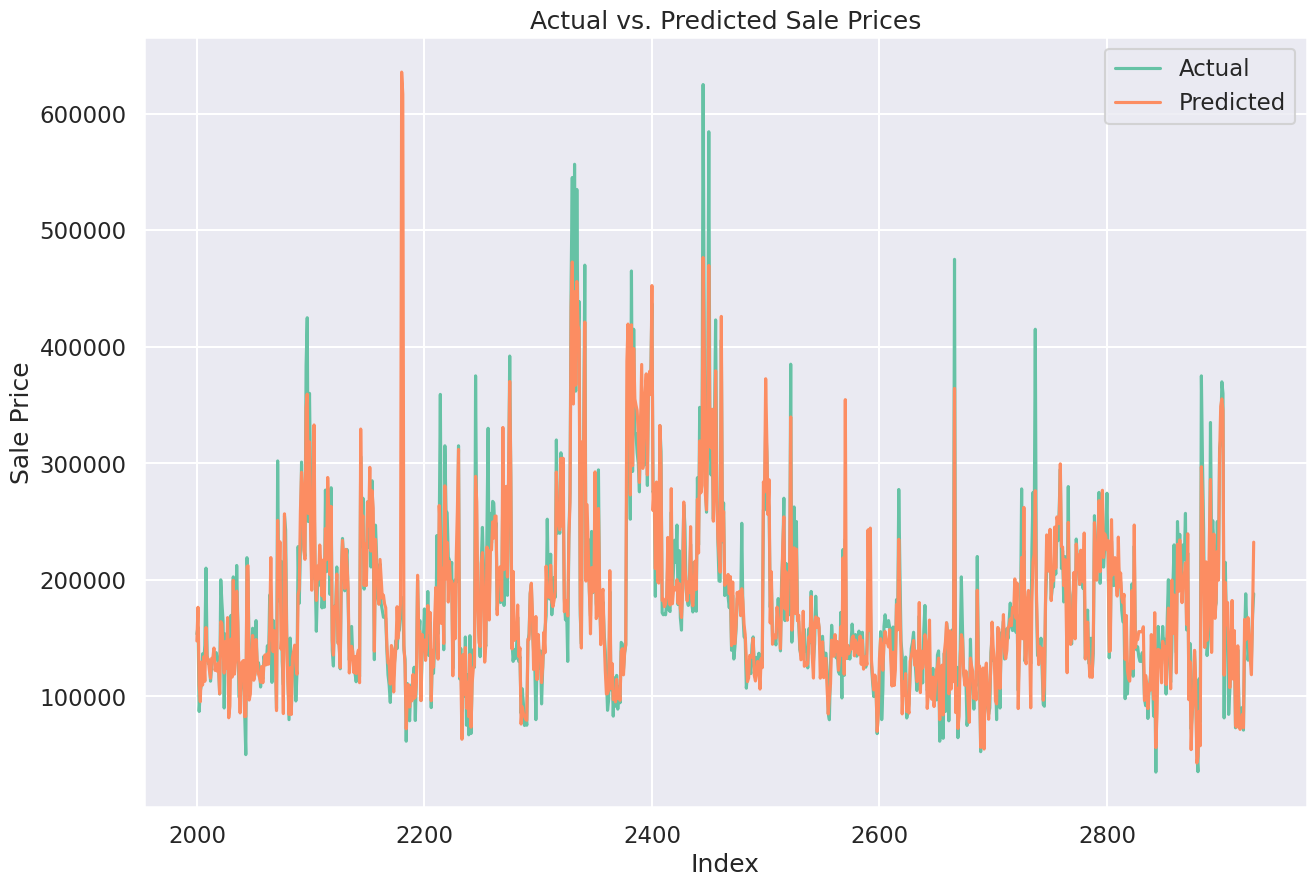

R²: 0.8368525376992535
Mean Squared Error: 966627926.4209247


In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(test.index, y_test, label='Actual')
ax.plot(test.index, y_test_pred, label='Predicted')

ax.set_xlabel('Index')
ax.set_ylabel('Sale Price')
ax.set_title('Actual vs. Predicted Sale Prices')
ax.legend()

plt.show()

r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f"R²: {r2}")
print(f"Mean Squared Error: {mse}")
